This notebook is contains a truncated version of our bot's backend code, rewritten to disassociate from Discord so that evaluation on its output can be performed easier. The targeted output is a series of confusion matrix evaluating the performance of our backend against Jigsaw's Conversation AI training set.

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


please upload train.csv from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Setup -- adapted from bot code

In [3]:
from googleapiclient import discovery
import json
import os
from unidecode import unidecode


PERSPECTIVE_AUTODELETE_THRESHOLD = 0.9

SENSITIVITY_MODES = {
    "Extra Strict": 0.3,
    "Strict": 0.5,
    "Moderate": 0.7,
    "Loose": 0.9,
}

REPORT_HIERARCHY = {
    "THREAT",
    "SEXUALLY_EXPLICIT",
    "SEVERE_TOXICITY",
    "IDENTITY_ATTACK",
    "INSULT",
    "TOXICITY"
}

SPAM_CHOICE = "Spam"
HARASSMENT_CHOICE = "Harassment"
OFFENSIVE_CHOICE = "Offensive Content"
THREAT_CHOICE = "Threats"
OTHER_CHOICE = "Other"

SCAM_CHOICE = "Scam"
SOLICITATION_CHOICE = "Solicitation"
UNWANTED_MSG_CHOICE = "Repeated Unwanted Messages"
BOT_CHOICE = "Bot"

APPEARANCE_CHOICE = "Appearance Attack"
SEXUAL_HARASSMENT_CHOICE = "Sexual Harassment"
TARGET_ATTACK_CHOICE = "Targeted Attack"
PERSONAL_INFO_CHOICE = "Revealing Personal Info"

HATE_SPEECH_CHOICE = "Hate Speech"
SEXUAL_CONTENT_CHOICE = "Sexual Content"

SWAT_CHOICE = "Threat to SWAT"
CYBER_ATTACK_CHOICE = "Threat to Cyber Attack"
SELF_HARM_CHOICE = "Self-Harm"
VIOLENT_MESSAGING_CHOICE = "Violent Messaging"


REPORTING_TEXT_OPTIONS = [SPAM_CHOICE, HARASSMENT_CHOICE, OFFENSIVE_CHOICE, THREAT_CHOICE, OTHER_CHOICE]
SPAM_TEXT_OPTIONS = [SCAM_CHOICE, SOLICITATION_CHOICE, UNWANTED_MSG_CHOICE, BOT_CHOICE, OTHER_CHOICE] 
HARASSMENT_TEXT_OPTIONS = [APPEARANCE_CHOICE, SEXUAL_HARASSMENT_CHOICE, TARGET_ATTACK_CHOICE, PERSONAL_INFO_CHOICE, OTHER_CHOICE]
OFFENSIVE_CONTENT_TEXT_OPTIONS = [HATE_SPEECH_CHOICE, SEXUAL_CONTENT_CHOICE, OTHER_CHOICE]
THREAT_TEXT_OPTIONS = [SWAT_CHOICE, CYBER_ATTACK_CHOICE, SELF_HARM_CHOICE, VIOLENT_MESSAGING_CHOICE, OTHER_CHOICE]



ATTRIBUTE_MAPPING = {
    "THREAT": [THREAT_CHOICE, OTHER_CHOICE],
    "SEXUALLY_EXPLICIT": [OFFENSIVE_CHOICE, SEXUAL_CONTENT_CHOICE],
    "SEVERE_TOXICITY": [HARASSMENT_CHOICE, TARGET_ATTACK_CHOICE],
    "IDENTITY_ATTACK": [OFFENSIVE_CHOICE, HATE_SPEECH_CHOICE],
    "INSULT": [HARASSMENT_CHOICE, TARGET_ATTACK_CHOICE],
    "TOXICITY": [HARASSMENT_CHOICE, TARGET_ATTACK_CHOICE],
}

class Report_Details:
    def __init__(self):
        self.message_id = None
        self.message_content = None
        self.reporter = None
        self.report_reason = None
        self.report_subcategory = None
        self.organized_attack = None
        self.author = None
        self.channel = None
        self.auto_flagged = 0



necessary functions -- adapted from existing bot code

In [4]:
def parse_perspective_response(response):
    attribute_scores = {}
    for attribute in response['attributeScores'].keys():
        attribute_scores[attribute] = response['attributeScores'][attribute]['summaryScore']['value']
    return attribute_scores

def get_message_report_type(msg_attributes, sensitivity):
    for attribute in REPORT_HIERARCHY:
        if msg_attributes[attribute] > sensitivity:
            return attribute, msg_attributes[attribute]
    return None, None

# returns a report and associated confidence score, or None if the message is not toxic
def perspective_analyze_message(perspective_api_client, message, sensitivity = 0.7, normalize_message = True):
    #print("ANALYZING MESSAGE")
    #print("sense", sensitivity)
    
    message_string = message.content

    #print("MESSAGE BEFORE CLEANING: ", message_string)
    if normalize_message:
        message_string = clean_message(message_string)
    #print("MESSAGE AFTER CLEANING: ", message_string)

    analyze_request = {
        'comment': { 'text': message_string},
        'requestedAttributes': {'TOXICITY': {}, 'SEVERE_TOXICITY': {}, 'IDENTITY_ATTACK': {}, 'INSULT': {}, 'THREAT': {}, 'SEXUALLY_EXPLICIT': {}}
        }
    response = perspective_api_client.comments().analyze(body=analyze_request).execute()
    parsed_response = parse_perspective_response(response)
    return parsed_response
    # report_type, score = get_message_report_type(parsed_response, sensitivity)

    # print('next is parsed')
    # print(parsed_response)
    # print("MSG CATEGORY:", report_type, "with score", score)
    # print()
    # return generate_report(message, report_type), score

def generate_report(message, report_type):
    if report_type is None:
        return None
    auto_report_details = Report_Details()
    auto_report_details.message_id = message.id
    auto_report_details.message_content = message.content
    auto_report_details.reporter = None
    auto_report_details.report_reason = ATTRIBUTE_MAPPING[report_type][0]
    auto_report_details.report_subcategory = ATTRIBUTE_MAPPING[report_type][1]
    auto_report_details.organized_attack = 0
    auto_report_details.author = message.author.name
    auto_report_details.message_content = message.content
    auto_report_details.channel = message.channel
    auto_report_details.auto_flagged = 1
    return auto_report_details

# Message (discord message object, message.content contains the text)
def get_classification_result(perspective_api_client, message, sensitivity = 0.7, normalize_message = True):
    report, score = perspective_analyze_message(perspective_api_client, message, sensitivity = sensitivity, normalize_message = normalize_message)
    if report is None:
        return None, score
    else:
        return report.report_reason, score

def clean_message(msg):
    lowered = msg.lower()
    unidecoded  = unidecode(lowered)
    return unidecoded

perspective API token

In [5]:
perspective_token = ''

get_classification test run

In [8]:
from googleapiclient import discovery
perspective_api_client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=perspective_token,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

class newAuthor:
  def __init__(self, name):
    self.name = name

class Message:
  def __init__(self, content):
    self.content = content
    self.id = 13212412
    self.author = newAuthor("dummy")
    self.channel = "dummy"

m1 = Message("how are you doing bro?")

perspective_analyze_message(perspective_api_client, m1)


HttpError: ignored

predict and generate classification report

In [ ]:
import csv
import sklearn.metrics as skm
import numpy as np


SENSITIVITY = 0.5

num = 3000

y_true = []
y_pred = []
with open('/train.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
      m1 = Message(row[1])

      try:
         result = perspective_analyze_message(perspective_api_client, m1)
      except: 
        continue
      
      messageLabel = list([eval(i) for i in row[2:8]]) #order is toxic, severe toxic, sexually explicit, threat, insult, identity attack 
      y_true.append(messageLabel)
      
      predictedLabel = [1 if result["TOXICITY"] > SENSITIVITY else 0, 1 if result["SEVERE_TOXICITY"] > SENSITIVITY else 0, 1 if result["SEXUALLY_EXPLICIT"] > SENSITIVITY else 0,1 if result["THREAT"] > SENSITIVITY else 0, 1 if result["INSULT"] > SENSITIVITY else 0, 1 if result["IDENTITY_ATTACK"] > SENSITIVITY else 0]
      y_pred.append(predictedLabel)
      num -= 1
      if num == 0: break
  
print(y_true)
print(y_pred)


y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
target_names = ["TOXIC", "SEVERE_TOXIC", "SEXUALLY_EXPLICIT", "THREAT", "INSULT", "IDENTITY ATTACK"]
print( skm.classification_report(y_true,y_pred, target_names=target_names))

prettyprint confusion matrix

In [83]:
skm.multilabel_confusion_matrix(y_true, y_pred)

array([[[253,   7],
        [  7,  33]],

       [[288,   9],
        [  1,   2]],

       [[275,   1],
        [ 16,   8]],

       [[297,   1],
        [  0,   2]],

       [[267,  14],
        [  1,  18]],

       [[294,   1],
        [  0,   5]]])

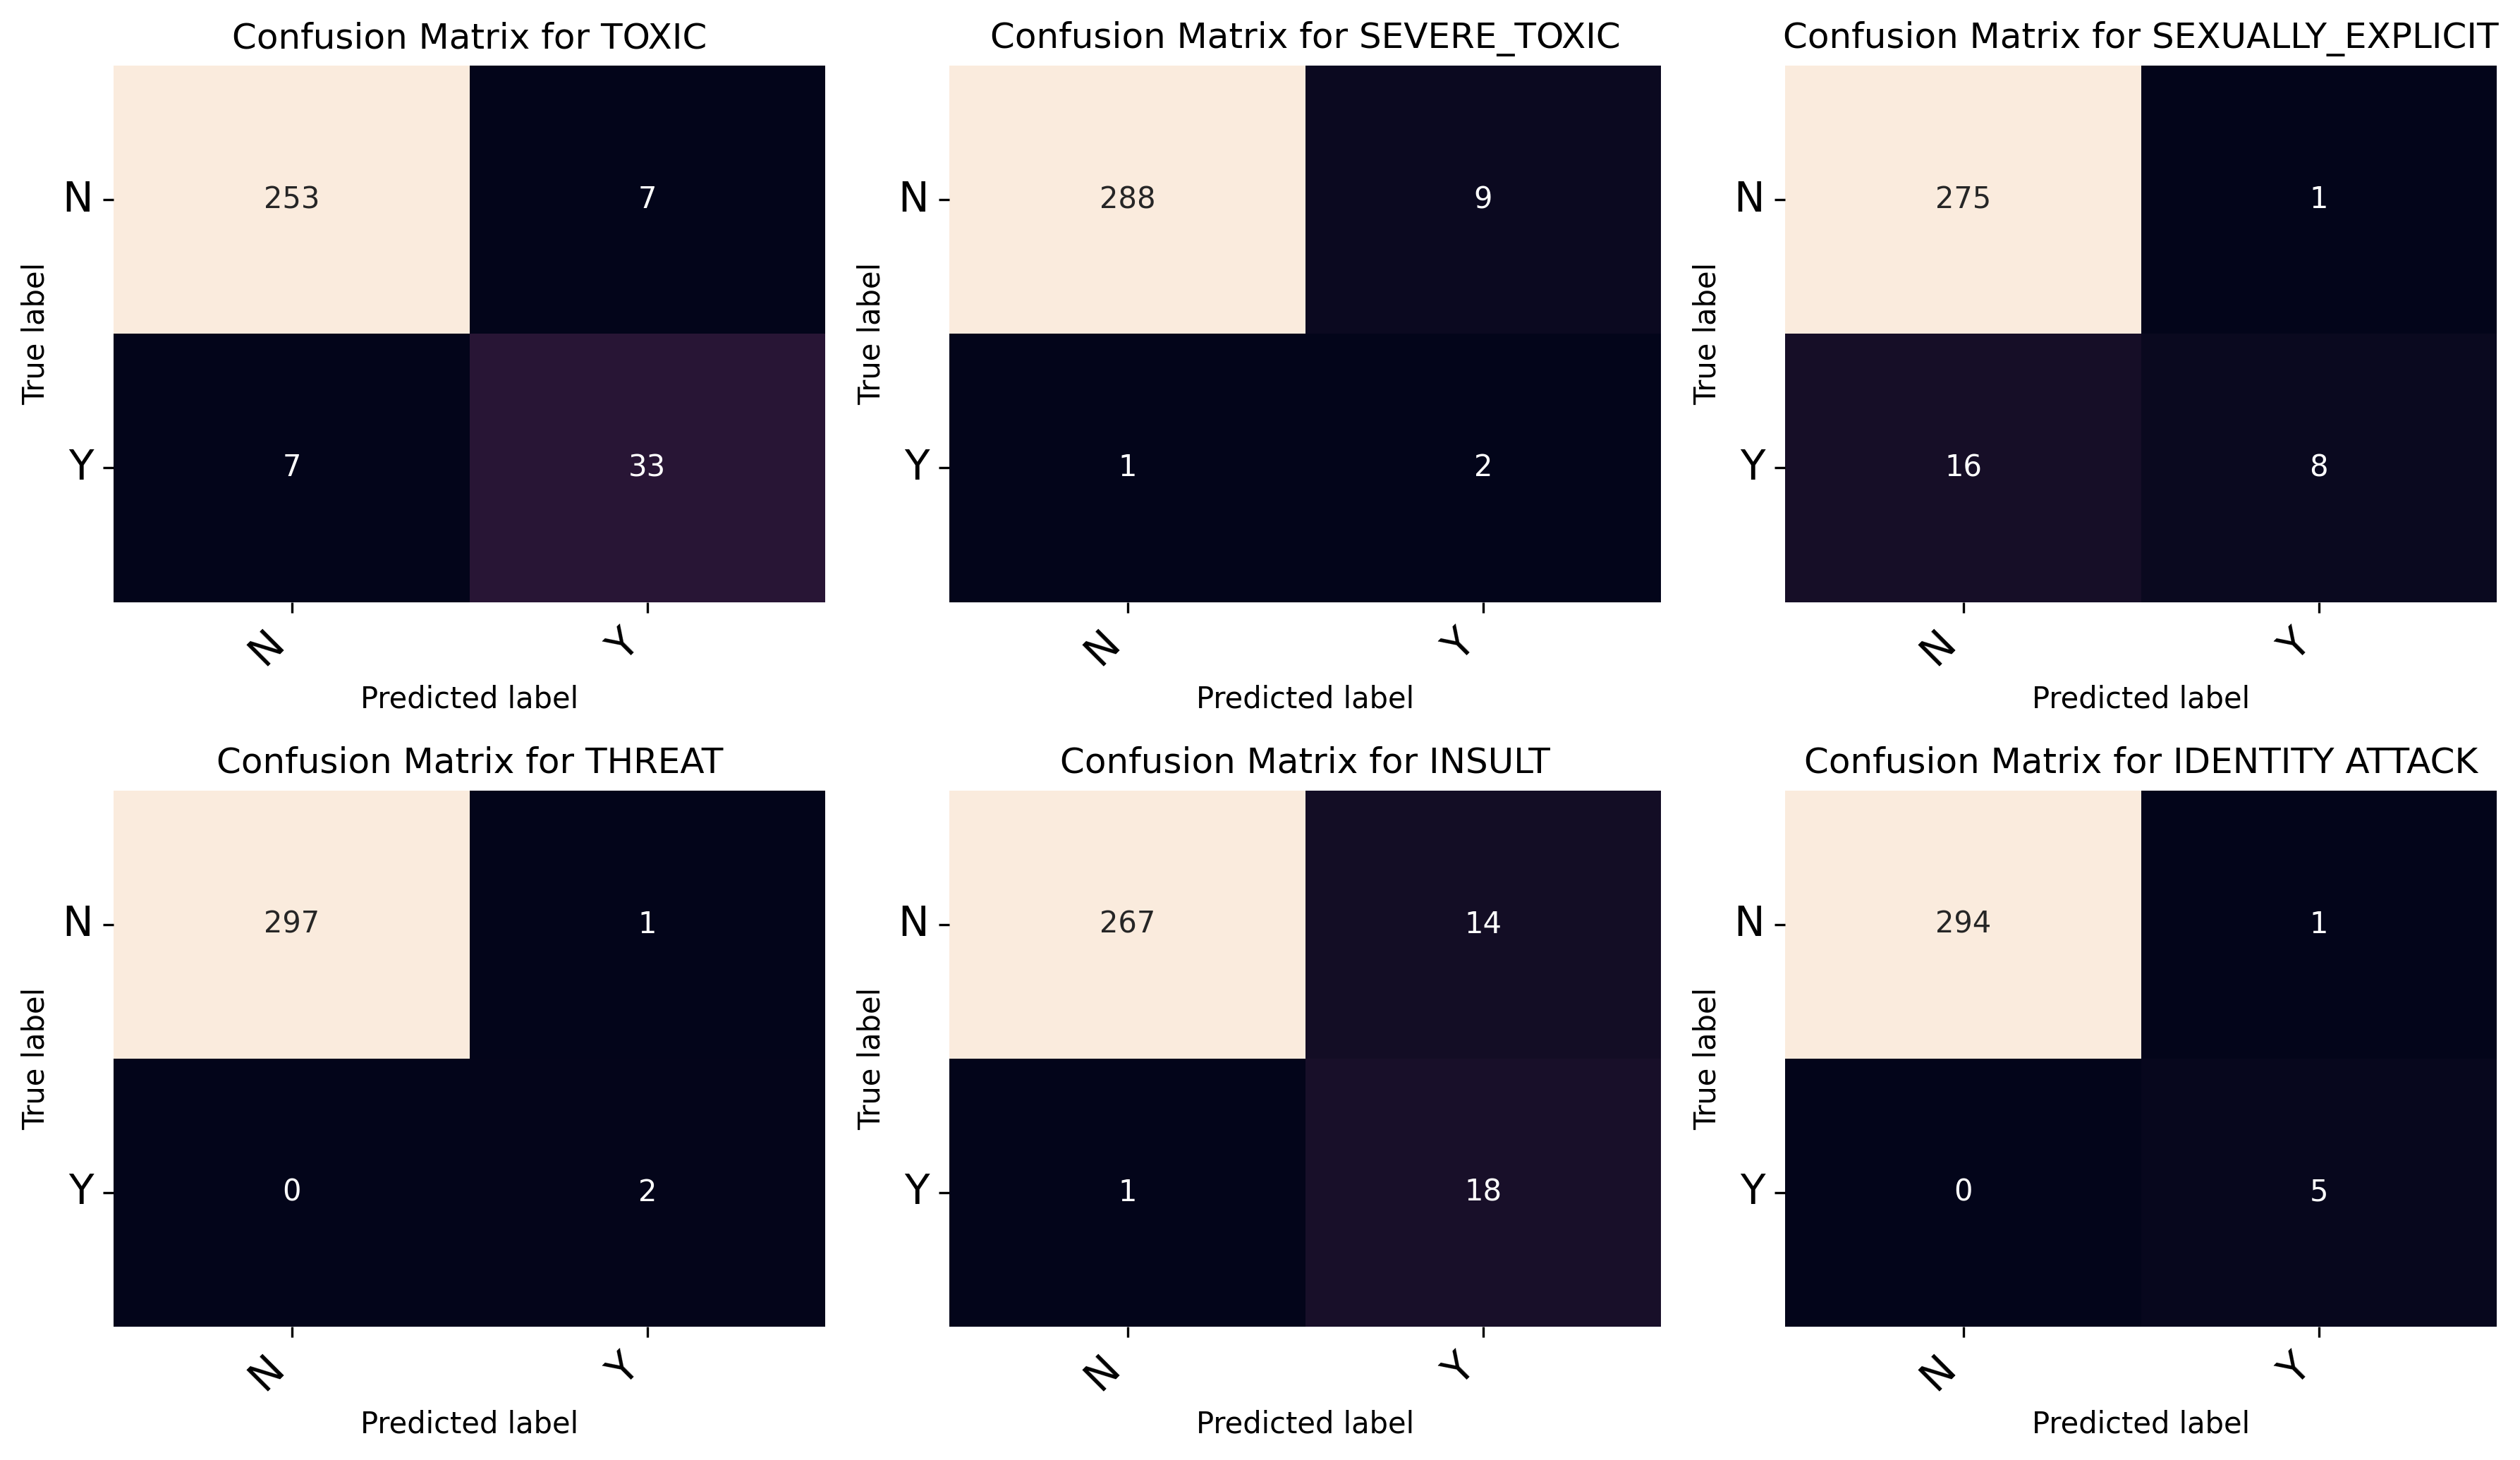

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#vis_arr = skm.multilabel_confusion_matrix(y_true, y_pred)
labels = ["TOXIC", "SEVERE_TOXIC", "SEXUALLY_EXPLICIT", "THREAT", "INSULT", "IDENTITY ATTACK"]
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for " + class_label)

fig, ax = plt.subplots(2, 3, figsize=(12, 7), dpi=300)
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()

fig.savefig('file.png')
plt.show()
